In [1]:
import PollingSystem as PS
import MarkovianRP as MRP
import numpy as np

from matplotlib import pyplot as plt
from importlib import reload 

In [3]:
reload(PS)
beta = 1/16
els = np.array([0.3, 0.01, 0.01])/beta
#els = np.array([0.3, 0.1, 0.1])/beta
ps = PS.PollingSystem(els, beta)
S = np.array([[ 0.        , 11.01635149, 14.27059899],
       [11.01635149,  0.        , 17.132717  ],
       [14.27059899, 17.132717  ,  0.        ]])

pi = np.array([0.99764782, 0.00135218, 0.001])
#pi = np.array([1/3, 1/3, 1/3])
rp = MRP.RandomRP(pi)
wait = ps.calc_avg_wait(rp, S)
print("Theoretical Wait Time: %.4f"%(wait))
wait2 = ps._calc_avg_wait_random2(S, pi)
print("Theoreical Wait Time 2: %.4f"%(wait2))
hrs = 2
mins = hrs*60
seconds = mins*60
xt, wt, queues, avg_switching, polling_instants = ps.simulate(rp, S, seconds)


Theoretical Wait Time: 10.1697
23.889025815649624
[23.40865309]
[4.38178188]
Theoreical Wait Time 2: 8.3195


Empirical Wait Time: 15.0385
Diff: 4.8688 (0.3238) 
Empirical pi:  [0.99741653 0.00154217 0.0010413 ]
Lbar MC Emp: 16.5457
lbar mc thr: 23.8890
Empirical lbar:78.070928
Thr W based on empirical lbar: 15.248228
Expected Lbar: 52.0687
Theoretical Lbar: 42.5959
Empirical Average Switching: 0.064279
thr Average Switching: 0.058243
Empirical average stage duration: 0.0949
Theoretical average stage duration: 0.0857




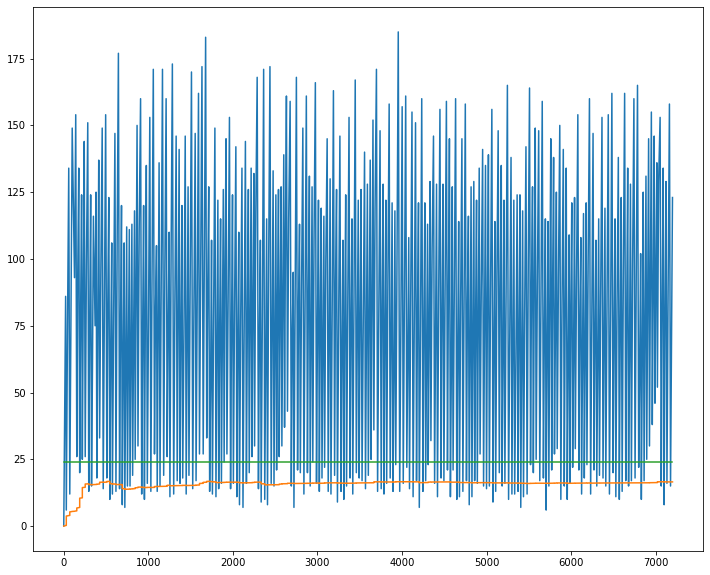

In [13]:
xt = np.array(xt)
print('Empirical Wait Time: %.4f'%(wt[-1][1]))
#     print("Avg Switching: %f"%(avg_switching))
diff = wt[-1][1] - wait
print("Diff: %.4f (%.4f) "%(diff, diff/wt[-1][1]) )

int_queue_length = 0
average_at_polling = 0
for i in range(len(xt)-1):
    int_queue_length += (xt[i+1][0]-xt[i][0])*sum(xt[i][2:])
Lbar_mc = 0
plgis = np.array(polling_instants)
uni, counts = np.unique(plgis[:,1], return_counts = True)
print("Empirical pi: ", counts/sum(counts))

Lbarmc = 0
sys_lengths = []
for inst in plgis[:,0]:
    idx = np.where(xt[:,0]==inst)
#     print(idx)
    sys_lengths.append(sum(xt[idx[0][0],2:]))
    Lbarmc += sys_lengths[-1]
plt.figure(figsize=(12,10))   
plt.plot(plgis[:,0], sys_lengths)
plt.plot(plgis[:,0], np.cumsum(sys_lengths)/np.arange(1,len(sys_lengths)+1,1) )
print("Lbar MC Emp: %.4f"%(Lbarmc/len(plgis)))
Lmc = ps._LSys_mc_avg(S, pi)
print("lbar mc thr: %.4f"%(Lmc))
plt.plot([0,plgis[-1,0]], [Lmc, Lmc])


    
lbar = int_queue_length/xt[-1][0]
print("Empirical lbar:%f" %(lbar))
#littles_law_wait
print("Thr W based on empirical lbar: %f"%(lbar/sum(els)))
print('Expected Lbar: %.4f'%(wait*sum(els)))#over all time
print("Theoretical Lbar: %.4f"%(wait2*sum(els)))
print("Empirical Average Switching: %f"%( avg_switching))
sbar = pi.T@ S @pi
print("thr Average Switching: %f"%(sbar))

print("Empirical average stage duration: %.4f"%( (plgis[-1,0] - plgis[0,0])/(len(plgis) -1) ))
print("Theoretical average stage duration: %.4f"%(sbar/(1-beta*sum(els))))
print("\n")

In [3]:
def pi_toPandNewPi(pi):
    n = len(pi)
    #calculate true probability transitions
    P = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i != j:
                P[i,j] = pi[j]
        P[i,:] /= sum(P[i,:])
    v, M = np.linalg.eig(P.T)

    pi_obs = M[:,0]/sum(M[:,0])
    return P, pi_obs

In [6]:
beta = 1/16
ps = PS.PollingSystem(np.array([0.3, 0.01, 0.01])/beta, beta)

rp = MRP.RandomRP([1/3, 1/3, 1/3])
s = 10
d = 500
for v in [1,2,4,8,100000]:
    S =  np.array([[0, s, d],[s, 0, np.sqrt(d+s**2)],[1.5, np.sqrt(d+s**2), 0]])/v
    wait = ps.calc_avg_wait(rp, S)
    print("Theoretical Wait Time: %f"%(wait))

Theoretical Wait Time: 261.173551
Theoretical Wait Time: 130.594128
Theoretical Wait Time: 65.304417
Theoretical Wait Time: 32.659561
Theoretical Wait Time: 0.017317


In [2]:
#NOTE: decreasing switching time does NOT guarantee decreasing average waiting time

In [7]:
len(polling_instants)

75867

Empirical average inter arrival: 0.196736
Thr average inter arrival: 0.195312


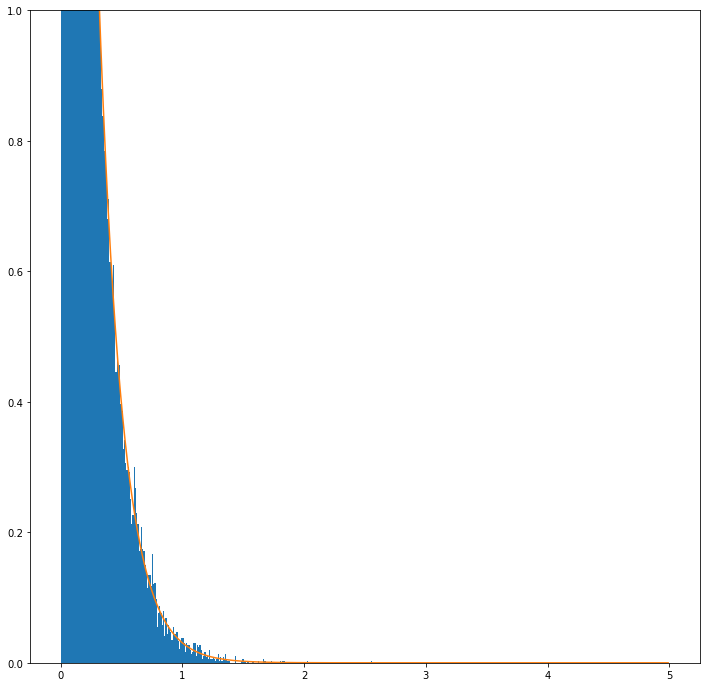

2.5513306770370434
36598


In [31]:
arrivals = ps._generate_arrivals(seconds)
diffs = 0
diffsT = []
diffs0 = []
diffs1 = []
diffs2 = []
for i in range(len(arrivals)-1):
    diffsT.append(arrivals[i+1][0] - arrivals[i][0])
    diffs += (arrivals[i+1][0] - arrivals[i][0])
inter_arrival = diffs/(len(arrivals)-1)
print("Empirical average inter arrival: %f"%(inter_arrival))
print("Thr average inter arrival: %f"%(1/(sum(els))))
plt.figure(figsize=(12,12))
plt.hist(diffsT, range=(0,5), bins=500, density= True)
x = np.arange(0,5,0.01)
el = sum(els)
y = el*np.exp(-el*x)
plt.plot(x,y)
plt.ylim(0, 1)
plt.show()
print(np.max(diffsT))
print(len(arrivals))

In [8]:
#Scratch Pad
z = np.array([1,2,3,4,5])
z[1:]

array([2, 3, 4, 5])

In [20]:
q=0
samples=len(wt)*20
qs = []
for i in range(samples):
    q = rp.next(q)
    qs.append(q)
    
u, counts = np.unique(qs, return_counts = True)
print(pi)
print(counts/samples)
print(u)

print(pi_toPandNewPi(pi))
print(pi_toPandNewPi(counts/samples))

[0.99764782 0.00135218 0.001     ]
[0.99774425 0.00119132 0.00106443]
[0 1 2]
(array([[0.        , 0.57486247, 0.42513753],
       [0.99899865, 0.        , 0.00100135],
       [0.99864647, 0.00135353, 0.        ]]), array([0.49971206, 0.28755365, 0.21273429]))
(array([[0.        , 0.528125  , 0.471875  ],
       [0.9989343 , 0.        , 0.0010657 ],
       [0.99880742, 0.00119258, 0.        ]]), array([0.49971845, 0.26419536, 0.2360862 ]))


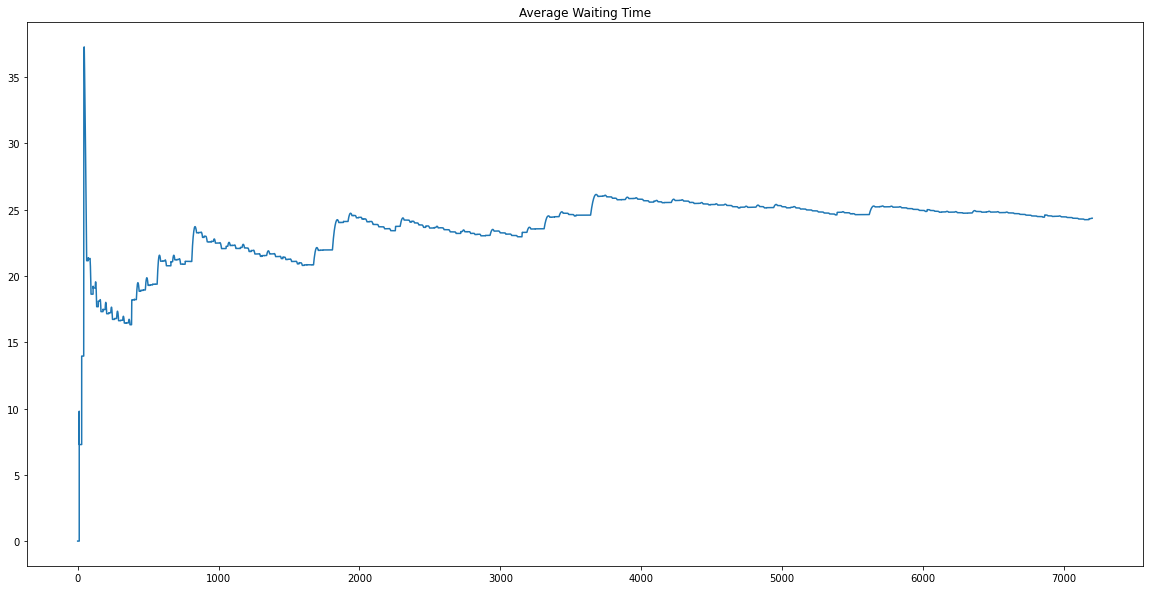

In [6]:
wt = np.array(wt)
fig = plt.figure(figsize=[20,10])
plt.plot(wt[:,0], wt[:,1])
plt.title("Average Waiting Time")
#plt.xlim(6500,8000)
#plt.ylim(12,13)
plt.show()

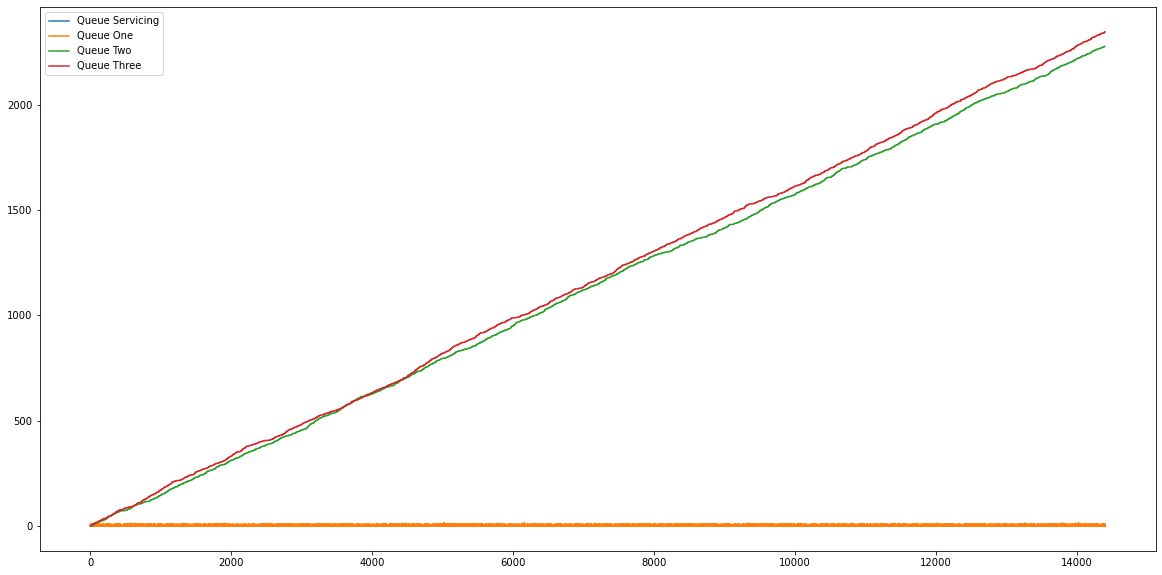

In [50]:
xt = np.array(xt)
fig = plt.figure(figsize=[20,10])
plt.plot(xt[:,0], xt[:,1], label = 'Queue Servicing')
plt.plot(xt[:,0], xt[:,2], label = 'Queue One')
plt.plot(xt[:,0], xt[:,3], label = 'Queue Two')
plt.plot(xt[:,0], xt[:,4], label = 'Queue Three')
plt.legend()
# plt.xlim(6500,8000)
# plt.ylim(-2,110)
plt.show()

In [47]:
def tail_avg_wait(queues, tail_start, Ls):
    avg = 0
    for i in range(len(queues)):
        queue = queues[i]
        sst = queue.service_start_times
        upper_i = len(sst) - 1
        lower_i = 0
        while upper_i - lower_i != 1:
            test_i = (upper_i + lower_i)//2
            if sst[test_i] < tail_start:
                lower_i = test_i
            elif sst[test_i] > tail_start:
                upper_i = test_i
            else:
                upper_i = test_i
                lower_i = test_i-1
        q_tail = queue.wait_times[upper_i:]
        avg += Ls[i]*np.mean(q_tail)
    return avg/np.sum(Ls)

tail_avg_wait(queues, 1000, els)

3.465431053486929

In [49]:
res = ps.calc_optiaml_rp(S)
print(res)

     fun: 4.906031021147757
     jac: array([3.89966959, 3.89420819, 3.89767259])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([0.07410498, 0.0310437 , 0.89485132])


4.906647130845505


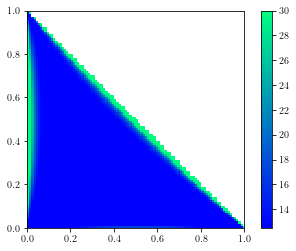

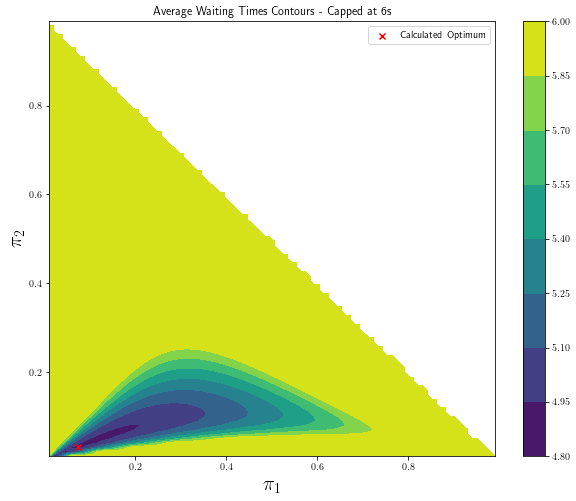

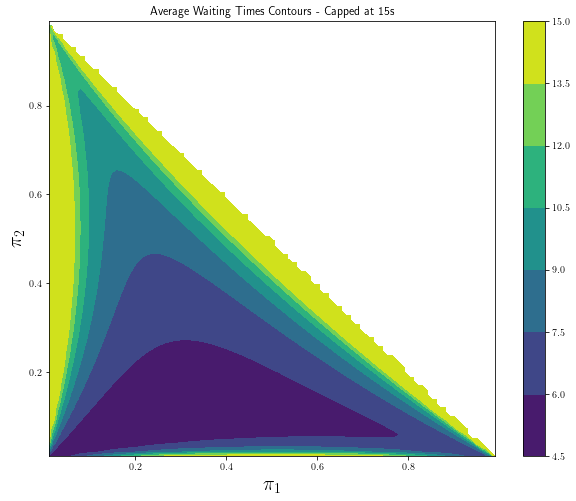

In [50]:
import matplotlib
matplotlib.rcParams['text.usetex'] = True

gran = 100
pi1 = np.linspace(1/gran,1-(1/gran), gran)
pi2 = np.linspace(1/gran,1 - (1/gran), gran)
Z = -1*np.Inf*np.ones([gran, gran])

fmin = 10000
for i in range(gran):
    for j in range(gran):
        pi = np.array([pi1[i], pi2[j], 1 - pi1[i] - pi2[j]])
        if pi[2] > 0:
            Z[i,j] = ps._calc_avg_wait_random( pi , S)
            if Z[i,j] < fmin:
                fmin=Z[i,j]
print(fmin)

fig, ax = plt.subplots()
ws = ax.imshow(np.transpose(Z), extent=[0,1,0,1], cmap='winter', interpolation='nearest',
               vmin=12.5,vmax=30, origin='lower')
fig.colorbar(ws)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 6))
#cont = plt.contourf(pi1, pi2, np.minimum(np.log(Z.T), 2.6) )
fig.colorbar(cont)
plt.scatter(res.x[0], res.x[1], label='Calculated Optimum', marker='x', c='r')
plt.legend()
plt.title('Average Waiting Times Contours - Capped at 6s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

fig = plt.figure(figsize=(10,8))
cont = plt.contourf(pi1, pi2, np.minimum(Z.T, 15))
fig.colorbar(cont)
plt.title('Average Waiting Times Contours - Capped at 15s')
plt.xlabel('$\pi_1$', fontsize=20)
plt.ylabel('$\pi_2$', fontsize=20)
plt.show()

In [10]:
#Contours are clearly non-convex. We're not dealing with a convex function.
#There doesn't seem to be a good way to verify unimodality, either

In [6]:
wt

[[0.0, 0.0],
 [1.0, 0.0],
 [11.449489742783172, 4.810577276457236],
 [25.449489742783197, 5.996869125095654],
 [33.44948974278322, 6.458916438928569],
 [40.44948974278325, 6.480595434554741],
 [50.89897948556646, 6.495536639019141],
 [55.898979485566485, 6.295950639937349],
 [55.898979485566485, 6.295950639937349],
 [58.348469228349664, 6.295950639937349],
 [65.79795897113286, 5.997687341029218],
 [77.24744871391592, 5.830234607921931],
 [79.69693845669909, 5.830234607921931],
 [86.14642819948214, 5.649665045990662],
 [88.59591794226532, 5.649665045990662],
 [94.04540768504837, 5.49338414176035],
 [109.49489742783143, 5.4298376091362535],
 [117.49489742783132, 5.522395360703529],
 [125.4948974278312, 5.541757494263057],
 [133.4948974278311, 5.496274189275127],
 [145.29285639896372, 5.410620023156765],
 [153.2928563989636, 5.459660619274925],
 [158.2928563989636, 5.459660619274925],
 [161.2928563989635, 5.503703183759251],
 [174.29285639896338, 5.541463198900879],
 [177.29285639896327, 